# **Song Recommendation Using Clustering**

In this notebook, we will implement a solution for a **Recommender System of Music**. Given some playlists available on Spotify (created by users or Spotify itself), the system will extract **features** for all **tracks** within the playlists and suggest 5 (or more) songs based on these extracted features. We say "5 or more" since the number of suggestions can be modified in the code. We will utilize the **Spotipy** library to retrieve the necessary data.

***Spotipy*** is a Python library that provides a convenient way to interact with the Spotify Web API. It acts as a wrapper around the API, allowing developers to easily access and manipulate Spotify's extensive collection of music data. With Spotipy, we can search for tracks, albums, and artists, retrieve audio features of songs, create playlists, manage a user's library, and perform various other operations.

# **Import**

In [1]:
import sys
if sys.version_info[0:2] != (3, 11):
    raise Exception('Requires python 3.11.5')

In [3]:
%%capture
%pip install --upgrade pip
%pip install spotipy
%pip install plotly_express
%pip install scikit-learn
%pip install scikit-learn-extra
%pip install yellowbrick
%pip install nbformat
%%clear

In [2]:
import spotipy
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials

import sklearn
import time
import math
import random
import os.path
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn_extra.cluster import KMedoids

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# **Variables Needed in the Notebook**

Before delving into the required steps for suggesting songs, let's provide a brief description of the features of the tracks we will be working with:

- **Acousticness**: This feature represents the acoustic quality of a track. A value of 0 indicates a track that is highly electronic or synthetic, while a value of 1 represents a track that is purely acoustic.

- **Danceability**: Danceability is a measure of how suitable a track is for dancing based on various musical elements. It takes into account factors like tempo, rhythm stability, beat strength, and overall regularity. A higher value indicates a track that is more danceable.

- **Energy**: Energy represents the intensity and activity level of a track. It measures features such as loudness, dynamic range, and perceived intensity. Higher values indicate more energetic tracks.

- **Instrumentalness**: This feature measures the likelihood of a track being instrumental. A value closer to 1 suggests that the track is likely instrumental, while a value closer to 0 indicates the presence of vocals.

- **Liveness**: Liveness indicates the presence of a live audience in a track. A higher value represents a greater probability of the track being performed live.

- **Loudness**: Loudness represents the overall volume of a track in decibels (dB). Negative values indicate quieter tracks, while positive values indicate louder tracks.

- **Speechiness**: Speechiness measures the presence of spoken words in a track. Values closer to 1 indicate tracks that are predominantly spoken, such as podcasts or audiobooks, while values closer to 0 represent instrumental or non-speech-oriented tracks.

- **Tempo**: Tempo is the overall speed or pace of a track measured in beats per minute (BPM). It represents how fast or slow the track feels.


Here the possible values for each audio feature:

| Audio Feature      | Min Value                  | Max Value                  |
|--------------------|----------------------------|----------------------------|
| Acousticness       | 0.0                        | 1.0                        |
| Danceability       | 0.0                        | 1.0                        |
| Energy             | 0.0                        | 1.0                        |
| Instrumentalness   | 0.0                        | 1.0                        |
| Liveness           | 0.0                        | 1.0                        |
| Loudness           | (Varies for each track)    | (Varies for each track)    |
| Speechiness        | 0.0                        | 1.0                        |
| Tempo              | (Varies for each track)    | (Varies for each track)    |

The values of the '**Tempo**' and '**Loudness**' features are not restricted to a specific range, such as 0 to 1. They can have various numeric values depending on the specific track and are respectively expressed in BPM (Beats Per Minute) and dB (Decibels). Due to this reason, we will attempt to transform these values into a normalized range between 0 and 1.


Now we define some variables that are going to be used later in the notebook.

In [3]:
# Playlist in which we will store the playlists that are going to be read later in the code
playlistFolder = "data/"

# Columns' Labels needed when creating Dataframes of the Playlists later in the code
dataframeColumns = ['Name', 'Album', 'Artist', 'Release Date', 'Length', 'Popularity',
           'Acousticness', 'Danceability', 'Energy', 'Instrumentalness',
           'Liveness', 'Loudness', 'Speechiness', 'Tempo']

In [4]:
# ID and Secret of My Spotify App on Developer Spotify
spotifyClientId = "978d7e659f4440609a2399c869cc3e27"
spotifyClientSecret = "1b160cf5acf94d44922b14c3cc5b295a"

# Instances of the main elements needed from the Spotipy library in order to work with playlists and tracks
authManager = SpotifyClientCredentials(client_id = spotifyClientId, client_secret = spotifyClientSecret)
sp = spotipy.Spotify(auth_manager = authManager)

# **Methods**

## **Artists**

In [5]:
# Method that returns an Artist's URI given its name
def uriFinder(artist):

  artistCode = sp.search(q='artist:' + artist, type='artist', limit=1)

  if artistCode['artists']['items']:
      artist_uri = artistCode['artists']['items'][0]['uri']
  else:
      print('Artist not found.')

  return artist_uri

# Method that returns an Artist's Genre given its name
def getArtistGenreByName(artistName):

  artistURI = uriFinder(artistName)
  artist = sp.artist(artistURI)
  genre = artist['genres']
  return ', '.join(genre)

# Method that returns an Artist's Genre given its URI
def getArtistGenreByURI(artistURI):

  artist = uriFinder('Sleep Token')
  artist = sp.artist(artistURI)
  genre = artist['genres']
  return ', '.join(genre)

# Method that returns all the Albums of a given Artist
def albumFinder(artist, artistURI):

  albumsData = sp.artist_albums(artistURI, album_type = 'album')
  albums = albumsData['items']

  while albumsData['next']:
      albumsData = sp.next(albumsData)
      albums.extend(albumsData['items'])

  print("These are all " + artist + "\'s albums found on Spotify:\n")
  for x in range(len(albums)):
    print(str(x) + "° Album: " + albums[x]['name'])

# Method that returns the top 10 songs of a given Artist
def topSongs(artist, artistURI, targetCountry):

  topTracks = sp.artist_top_tracks(artistURI, country = targetCountry)

  topTenTracks = topTracks['tracks'][:10]

  print("These are %s \'s top %d songs in %s found on Spotify:\n" % (artist, len(topTenTracks), targetCountry))
  for x in range(len(topTenTracks)):
    print(str(x+1) + "° Track: " + topTenTracks[x]['name'])
    print(str(x+1) + "° Audio: " + topTenTracks[x]['preview_url'] + "\n")

## **Playlists and Tracks**

In [6]:
# Method that returns the name of a given Playlist
def getPlaylistName(playlist_id):
    playlist = sp.playlist(playlist_id)
    return playlist['name']

# Method that returns the IDs of every track in a given Playlist
def trackIDsFromPlaylist(user, playlistID):
    trackIDs = []
    offset = 0
    limit = 100

    while True:
        playlist = sp.user_playlist_tracks(user, playlistID, limit=limit, offset=offset)

        for elem in playlist['items']:
            track = elem['track']
            trackIDs.append(track['id'])

        offset += limit
        if len(playlist['items']) < limit:
            break

    return trackIDs

# Method that returns the features of every track in a given Playlist
def getTrackFeatures(trackID):

  trackDetails = sp.track(trackID)
  trackFeatures = sp.audio_features(trackID)

  # Track Info
  name = trackDetails['name']
  album = trackDetails['album']['name']
  artist = trackDetails['album']['artists'][0]['name']
  release_date = trackDetails['album']['release_date']
  lenght = trackDetails['duration_ms']
  popularity = trackDetails['popularity']

  # Track Features
  acousticness = trackFeatures[0]['acousticness']
  danceability = trackFeatures[0]['danceability']
  energy = trackFeatures[0]['energy']
  instrumentalness = trackFeatures[0]['instrumentalness']
  liveness = trackFeatures[0]['liveness']
  loudness = trackFeatures[0]['loudness']
  speechiness = trackFeatures[0]['speechiness']
  tempo = trackFeatures[0]['tempo']

  trackInfo = [name, album, artist, release_date, lenght, popularity,
           acousticness, danceability, energy, instrumentalness,
            liveness, loudness, speechiness, tempo]

  return trackInfo

# Method that returns the link to the preview of the track
def getTrackPreview(trackName, artistName):

    query = f"track:{trackName} artist:{artistName}"
    results = sp.search(q=query, type='track')

    for track in results['tracks']['items']:
        if track['name'].lower() == trackName.lower():
            artists = [artist['name'].lower() for artist in track['artists']]
            if artistName.lower() in artists:
                track_id = track['id']
                track_info = sp.track(track_id)
                preview_url = track_info['preview_url']
                return preview_url

    return None

# Method that assigns the Artist's Genre to each Track
def addArtistGenreToDF(dataframe):

  artists_list = dataframe['Artist'].unique().tolist()

  genres_list = []

  for artist in artists_list:
      genres_list.append(getArtistGenreByName(artist))

  artistGenre_mapping = dict(zip(artists_list, genres_list))
  print("%d artists and genres found." % len(artistGenre_mapping))

  dataframe['Genre'] = dataframe['Artist'].map(artistGenre_mapping)

# Method that normalizes the values of some columns within a given dataframe using the min max normalization
def minMaxNormalization(data, columns):

    minVals = data[columns].min()
    maxVals = data[columns].max()
    rangeVals = maxVals - minVals

    normalized_data = data.copy()
    normalized_data[columns] = (data[columns] - minVals) / rangeVals

    return normalized_data

# Method that sorts a given dataframe
def sortDataframe(dataframe, label, threshold_val = 60, ascend = False):
  return dataframe.loc[dataframe[label] >= threshold_val].sort_values(by=[label], ascending = ascend)

# Method that computes the decade of a track
def getDecade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

## **Files**

In [7]:
def clearPlaylistName(tmpName):
    # Removes the char "|" if found due to the fact that files cant have it within their name
  if '|' in tmpName:
    return tmpName.replace("|", "")
  return tmpName

In [8]:
# Method that checks whether a file has already been stored or not
def checkFileExists(playlist_id):

  currentPlaylist = clearPlaylistName(getPlaylistName(playlist_id))
  
  file_name = str(currentPlaylist) + ".csv"
  file_path = playlistFolder + file_name

  if os.path.isfile(file_path):
      print("The playlist %s was already stored.\nChecking for differences..." % currentPlaylist)
      return True
  else:
      return False

# Method that reads a stored file
def readPlaylistDF(playlist_id):

  file_name = str(playlist_id) + ".csv"
  file_path = playlistFolder + file_name

  if os.path.isfile(file_path):
      dataframe = pd.read_csv(file_path)
      print("Playlist has been successfully loaded!")
      return dataframe
  else:
      print("File does not exist. Unable to load playlist.")
      return None

# Method that creates the Dataframe for a Playlist and stores it
def createPlaylistDF(playlist_id):

  tracks = trackIDsFromPlaylist("ivanrinaldi_", playlist_id)
  print("%d tracks have been found in the given playlist!\nExtracting features of each track..." % len(tracks))

  tracksFeatures = []

  for id in tracks:
    time.sleep(.20)
    tracksFeatures.append(getTrackFeatures(id))

  print("Feature for all %d songs have been extracted.\nCreating dataframe.." % len(tracks))

  tracksDF = pd.DataFrame(tracksFeatures, columns = dataframeColumns)
  print("The dataframe has been successfully created!")
  storePlaylistDataframe(playlist_id, tracksDF)
  return tracksDF

# Method that stores the Dataframe of a Playlist
def storePlaylistDataframe(playlist_id, dataframe):
  playlistName = getPlaylistName(playlist_id)
  file_name = playlistName + ".csv"
  file_path = playlistFolder + file_name
  dataframe.to_csv(file_path, index=False)
  print("Playlist has been successfully saved! - Playlist's Name: " + str(getPlaylistName(playlist_id)))

## **Clustering**

### **Random Search and Grid Search**

In [9]:
# Method that computes the Silhouette Score: used as the scoring for the Random Search and the Grid Search
def silhouette_scorer(estimator, X):
    labels = estimator.labels_
    try:
        score = silhouette_score(X, labels)
        return score
    except:
        # Return 0 if an error occurs
        return 0

### **Elbow Method | Elbow Curve | Silhouette Visualizer**

In [10]:
# Method that performs the Elbow Method and plots the results
def elbowMethod(processed_data, min_k_val = 1, max_k_val = 10):

  k_values = range(min_k_val, max_k_val)

  # List to store the within-cluster sum of squares (WCSS) values
  WCSSvals = []

  for k in k_values:
      kmedoids = KMedoids(n_clusters=k, init='k-medoids++', max_iter=100, random_state=42)
      kmedoids.fit(processed_data)
      WCSSvals.append(kmedoids.inertia_)

  elbow_data = pd.DataFrame({'k': k_values, 'WCSS': WCSSvals})

  fig = px.line(elbow_data, x = 'k', y = 'WCSS', title = 'Elbow Method')
  fig.update_layout(xaxis_title = 'Number of Clusters (k)', yaxis_title = 'Within-Cluster Sum of Squares (WCSS)')
  fig.show()

# Method that performs the Elbow Method and plots a better version of the results w.r.t. the previous method
def elbowCurveVisualizer(processed_data, min_k_val = 2, max_k_val = 10):

  km = KMedoids(random_state = 42)
  visualizer = KElbowVisualizer(km, k = (min_k_val, max_k_val))
  visualizer.fit(processed_data)
  visualizer.show()

# Method that computes the Silhouette Scores and plots a the results
def silhouetteVisualizer(processed_data, minClusters=2, maxClusters=10):

    n_plot = maxClusters - minClusters + 1

    if n_plot <= 3:
        rows = 1
        cols = n_plot
    else:
        rows = math.ceil(n_plot / 3)
        cols = 3

    fig, ax = plt.subplots(rows, cols, figsize=(12, 9))
    fig.suptitle('Silhouette Scores for Different Cluster Sizes', fontsize=13)

    silhouette_scores = []

    for i in range(minClusters, maxClusters + 1):

        km = KMedoids(n_clusters=i, init='k-medoids++', max_iter=100, random_state=42)

        q, mod = divmod(i - minClusters, cols)

        if rows == 1:
            visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[mod])
        else:
            visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])

        visualizer.fit(processed_data)
        visualizer.ax.set_title(f'k = {i}')
        visualizer.ax.set_xlabel('Silhouette Coeff. Values')
        visualizer.ax.set_ylabel('Cluster Label')
        visualizer.ax.set_xticks(np.arange(0, 1, 0.1))

        # We append the compute silhouette score in order to print the top 5
        silhouette_scores.append(visualizer.silhouette_score_)

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=0.35, wspace=0.3)
    plt.show()

    sorted_scores = sorted(silhouette_scores, reverse=True)

    print("Top Five Silhouette Scores:")
    for i in range(5):
        print("%d Clusters: %.4f" % (i+2, sorted_scores[i]))

### **K-Medoid**

In [11]:
# Method that performs the K-Medoids Clustering and returns the kmeans instance
def KMedoidsClustering(cluster_no, dataframe, processed_data, rndState = 42):

  k = cluster_no
  kmedoids = KMedoids(n_clusters = k, random_state = rndState)

  clusters = kmedoids.fit_predict(processed_data)

  dataframe['Cluster'] = clusters

  scatterPlot(dataframe, 'Loudness', 'Energy', 'Cluster', None, tit = "Clusters - Loudness/Energy")
  scatterPlot3D(dataframe, 'Energy', 'Liveness', 'Loudness', 'Cluster',
                None, tit = "Clusters - Energy/Liveness/Loudness")

  return kmedoids

# Method that counts the instances of all genres within each cluster and prints them
def countClusterGenreElems(dataframe):

  clusteredTrainTracks = dataframe.groupby('Cluster')

  genre_counts_df = pd.DataFrame(columns=['Cluster', 'Genre', 'Count'])

  for cluster_label, cluster_data in clusteredTrainTracks:
      genre_counts = cluster_data['Genre'].value_counts().reset_index()
      genre_counts.columns = ['Genre', 'Count']
      genre_counts['Cluster'] = cluster_label
      genre_counts_df = pd.concat([genre_counts_df, genre_counts])

  cluster_counts = dataframe['Cluster'].value_counts().sort_index()
  cluster_counts_df = pd.DataFrame(cluster_counts).reset_index()
  cluster_counts_df.columns = ['Cluster', 'Element Count']

  return cluster_counts_df

## **Recommend Songs**

In [12]:
# Euclidean distance between two songs
def euclideanDistance(track1, track2, features):

    track1Features = track1[features].values
    track2Features = track2[features].values

    distance = np.linalg.norm(track1Features - track2Features)

    return distance

# Function to recommend songs based on cluster
def recommend_songs(test_tracks_cluster, testTrack, cluster_label, num_recommendations, features):

    clusterTracks = test_tracks_cluster[test_tracks_cluster['Cluster'] == cluster_label]

    # Calculate similarity with the test song
    similarity_scores = []

    for index, track in clusterTracks.iterrows():

      # Avoids to compare between the test track and itself
      if track['Name'] != testTrack['Name']:
          similarity = euclideanDistance(testTrack, track, features)
          similarity_scores.append((index, similarity))

    if similarityFunc == 1:
      # Sort songs by similarity in descending order - Cosine Similarity
      similarity_scores.sort(key=lambda x: x[1], reverse=True)

    elif similarityFunc == 2:
      # Sort songs by similarity in ascending order - Euclidean Distance
      similarity_scores.sort(key=lambda x: x[1])

    # Recommend top songs
    recommended_songs = []
    
    for i in range(min(num_recommendations, len(similarity_scores))):
        song_index = similarity_scores[i][0]
        recommended_songs.append(clusterTracks.loc[song_index])

    return recommended_songs

## **Plot (Scatter Plot, Pie Chart)**

In [13]:
# Method that plots a 2D scatter chart that compares the Tracks of a given Plalylist based on two Features
def scatterPlot(dataframe, x_column, y_column, color_column, size_column, tit = "Scatter Plot"):

  fig = px.scatter(dataframe, x = x_column, y = y_column, color = color_column,
                 size = size_column, hover_data = {'Name': True, 'Artist': True},
                 title = tit)
  fig.show()

# Method that plots a 3D scatter chart that compares the Tracks of a given Plalylist based on three Features
def scatterPlot3D(dataframe, x_column, y_column, z_column, color_column, size_column, tit = "3D Scatter Plot"):
    fig = px.scatter_3d(dataframe, x=x_column, y=y_column, z=z_column, color=color_column,
                        size=size_column, hover_data={'Name': True, 'Artist': True},
                        title=tit)
    fig.show()

# Method that plots a scatter chart that compares the Tracks of a given Artist in a Plalylist based on two Features
def scatterPlotArtist(artistName, dataframe, x_lab, y_lab, color_lab, size_lab, tit = "Scatter Plot - Artist"):

  artistDF = dataframe[dataframe['Artist'] == artistName]

  x_column = artistDF[x_lab]
  y_column = artistDF[y_lab]
  color_column = artistDF[color_lab]
  size_column = artistDF[size_lab]

  fig = px.scatter(artistDF, x = x_column, y = y_column, color = color_column,
                 size = size_column, hover_data = {'Name': True, 'Artist': True},
                 title = tit)
  fig.show()

# Method that plots a pie chart
def pieChart(dataframe, val_column, names_column, tit = 'Pie Chart'):

  fig = px.pie(dataframe, values = val_column, names = names_column, title = tit)
  fig.show()

# Method that plots a pie chart that shows the 'Artist Distribution' within a Playlist
def pieChartArtist(dataframe, df_threshold_label, tit = 'Pie Chart', threshold_val = 60):

  thresholdedDf = dataframe[dataframe[df_threshold_label] > threshold_val]
  artist_counts = thresholdedDf['Artist'].value_counts()

  fig = px.pie(artist_counts, values = artist_counts.values, names = artist_counts.index, title = tit)
  fig.show()

# Method that plots a bar chart with the Number of Tracks by Decade
def decadeTracksPlot(dataframe, colors):

  trackDecades = []

  for i in range(len(dataframe)):

    tmpDate = dataframe.iloc[i]['Release Date'][:4]
    trackDecades.append(getDecade(int(tmpDate)))

  dataframe['Decade'] = trackDecades

  decadeCounts = dataframe['Decade'].value_counts().reset_index()
  decadeCounts.columns = ['Decade', 'Number of Tracks']
  decadeCounts = decadeCounts.sort_values('Decade')

  custColors = colors[:len(decadeCounts)]

  fig = px.bar(decadeCounts, x = 'Decade', y = 'Number of Tracks', title = 'Tracks By Decade', color = custColors)
  fig.show()

# **Spotipy Overview**

We've previously defined some methods that use the Spotipy APIs. Now, let's provide a brief overview of the data on artists and songs that can be extracted using the Spotipy library.

To begin, when given the name of an artist, we can retrieve a variety of data associated with them. This data comprises the Artist's Spotify page link, the URL to the artist's image displayed on their Spotify page, as well as other specific details such as name, genres, URI, and popularity. The APIs return the Artist's URI, which can be utilized for making additional queries about the artist.

In [14]:
sleepTokenURI = uriFinder('Sleep Token')
art1 = sp.artist(sleepTokenURI)
art1

{'external_urls': {'spotify': 'https://open.spotify.com/artist/2n2RSaZqBuUUukhbLlpnE6'},
 'followers': {'href': None, 'total': 723196},
 'genres': ['prog metal'],
 'href': 'https://api.spotify.com/v1/artists/2n2RSaZqBuUUukhbLlpnE6',
 'id': '2n2RSaZqBuUUukhbLlpnE6',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6761610000e5ebdbc568c9d871256b9a3e34a1',
   'width': 640},
  {'height': 320,
   'url': 'https://i.scdn.co/image/ab67616100005174dbc568c9d871256b9a3e34a1',
   'width': 320},
  {'height': 160,
   'url': 'https://i.scdn.co/image/ab6761610000f178dbc568c9d871256b9a3e34a1',
   'width': 160}],
 'name': 'Sleep Token',
 'popularity': 72,
 'type': 'artist',
 'uri': 'spotify:artist:2n2RSaZqBuUUukhbLlpnE6'}

By using the Artist's URI, we can retrieve all the albums published up to the present.

In [15]:
albumFinder(art1['name'], sleepTokenURI)

These are all Sleep Token's albums found on Spotify:

0° Album: Take Me Back To Eden
1° Album: Sundowning (Instrumental)
2° Album: This Place Will Become Your Tomb (Instrumental)
3° Album: This Place Will Become Your Tomb
4° Album: Sundowning (Deluxe)
5° Album: Sundowning


Using the Artist's URI, we can also access the current top songs in a specific country. A preview of each song is provided.

In [16]:
topSongs(art1['name'], sleepTokenURI, 'IT')

These are Sleep Token 's top 10 songs in IT found on Spotify:

1° Track: The Summoning
1° Audio: https://p.scdn.co/mp3-preview/37dae98703ecc268384d30ed33045254aa4198c9?cid=978d7e659f4440609a2399c869cc3e27

2° Track: Granite
2° Audio: https://p.scdn.co/mp3-preview/5b9517a8c2ce433d7bb137a67bc616599b09675a?cid=978d7e659f4440609a2399c869cc3e27

3° Track: Take Me Back To Eden
3° Audio: https://p.scdn.co/mp3-preview/2ec75ff949ee63d07be0371ecb5c7b3e368df09d?cid=978d7e659f4440609a2399c869cc3e27

4° Track: Chokehold
4° Audio: https://p.scdn.co/mp3-preview/668a47fd87e33cdea2d5af2ed5c1915796173c2d?cid=978d7e659f4440609a2399c869cc3e27

5° Track: Rain
5° Audio: https://p.scdn.co/mp3-preview/ad914c58173ea2260cf2f905406f2ff4de2b3341?cid=978d7e659f4440609a2399c869cc3e27

6° Track: Alkaline
6° Audio: https://p.scdn.co/mp3-preview/0965f397de2fe4fee17c02242f471ea2fda16e64?cid=978d7e659f4440609a2399c869cc3e27

7° Track: Aqua Regia
7° Audio: https://p.scdn.co/mp3-preview/03e3816f344580fc60a5f4e0fb6b0c19e60

By employing the 'user_playlist_tracks' function provided by Spotipy, we can retrieve the tracks within a user's Spotify playlist. To utilize this function, you'll require the playlist's ID, which can be located when sharing a playlist via a link (e.g., https://open.spotify.com/playlist/**7h9vStNqINIi5YNdrABFRv**?si=fbbac99222454256). In the method we've defined, we return the IDs of each song within the playlist, but additional data can be obtained as needed.

In [17]:
userPlaylist = "7h9vStNqINIi5YNdrABFRv"
tracks = trackIDsFromPlaylist("ivanrinaldi_", userPlaylist)
print(str(len(tracks)) + " songs have been found!\nHere all the IDs: " + str(tracks))

67 songs have been found!
Here all the IDs: ['060RNnzoMay3wKJek1faPc', '0ceW5TkemJUEmJERavfqQq', '3GHtEaicELsTViK08EXEQQ', '3Ddgh4ZwVIkLx0f4WeDFmo', '5IwUFTiNkarb5HEtNRtRtc', '1JdWRS3PBZlSgKcPKcULtr', '1oqMPCtRiO1QQLP8NjuB9Z', '3lPn81PFyKvXiyHhlkwkQ4', '1yYE8EyuIV0rrvQ1bA2Fyf', '0M3adYbGtyRHACP86dey1H', '1KTJmfwrk5pYqsi9mkY3nT', '6lFUdRItQEsEuD7dSINL47', '4EyPadLFhtWojU7mkT5hqT', '1wvs9V8xEJStRzx78lSNJK', '6o39Ln9118FKTMbM4BvcEy', '6r7bDk4J0Okw4ezTBUQXo3', '4Jynisl0QfolpNp5AbqMkQ', '66lNflR48s3C3a7DbjfDs0', '5M2K8KcAbyvjh1oq1enxI4', '40WI0bj0BjQBWSYTksegAZ', '1KAqeknDvEAmBEfGyJL6TR', '7Hf5ZkN0kLxwsM5GYwhIBg', '0AvZoW6Jk97t79EPRvfV0P', '0ba8MIPhoTh3WwGJUEGKPe', '7hntkdvG3jWdFKm7pGCCzd', '1DbdQp5dwuawBGmxSHw6Fr', '5gawwgpayyI5xRadHUAEvx', '0CrJVibIdsL6mqmYI9R9hc', '38NXH8WqiK5txwU0wwIcHn', '1DDN2rHzfzuKmaN0Qoo4lm', '1KbfMiKDVBCJxOTV9sWA8m', '644DRE86AOvnPwo0NMdJDi', '0zYxfgyqypkG7rRwFqyisT', '2eZjO58Qe9og2xmyfw4qwJ', '6PCuVdPENYbYwSnoWxxeTM', '6kuudUd50kADw1HmSGoT6X', '6xdyTobqWSlBW9LFNH

By utilizing the song IDs, we can access the song's data using the 'sp.track' function provided by Spotipy. In this example, we print the data of the first song in the user playlist.

In [18]:
track = sp.track(tracks[0])
print("The track's artist is: " + track['artists'][0]['name'])
print("The track's name is: " + track['name'])
print("All the track's data:\n" + str(track))

The track's artist is: Bring Me The Horizon
The track's name is: MANTRA
All the track's data:
{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1Ffb6ejR6Fe5IamqA5oRUF'}, 'href': 'https://api.spotify.com/v1/artists/1Ffb6ejR6Fe5IamqA5oRUF', 'id': '1Ffb6ejR6Fe5IamqA5oRUF', 'name': 'Bring Me The Horizon', 'type': 'artist', 'uri': 'spotify:artist:1Ffb6ejR6Fe5IamqA5oRUF'}], 'available_markets': ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR', 'ME', 'MK', 'RS', 'SI', 'KR', 'B

# **Import Playlists**

We will now import some default playlists created by some users that are available on Spotify. These playlists will serve as our train and test datasets.

In [87]:
# List of Playlists IDs:
# "3fSsw9Mp5Mi2DDiweZggtP" # Keep grinding || Training Set
# "2YRe7HRKNRvXdJBp9nXFza" # Spotify Most Played All Time 500Mil+  || Test Set
playlists = [ "3fSsw9Mp5Mi2DDiweZggtP", "2YRe7HRKNRvXdJBp9nXFza"]

print("The default playlists are:\n")
for p in playlists:
    print("Playlist's ID: %s || Name: %s" % (p, getPlaylistName(p)))

The default playlists are:

Playlist's ID: 3fSsw9Mp5Mi2DDiweZggtP || Name: keep grinding.
Playlist's ID: 2YRe7HRKNRvXdJBp9nXFza || Name: Spotify's Most Played All-Time [Updated Weekly] | Most Streamed | Top Played | 500Mil+


We also allow the user to add more playlists. Those will be used along with the default ones.

In [81]:
importPlaylist = (input("Do you want to import your playlists? Type Yes or No"))

while(importPlaylist.lower() != "yes" and importPlaylist.lower() != "no"):
    importPlaylist = (input("Invalid answer. Please write either Yes or No"))

# User does not want to add more playlists
if importPlaylist.lower() == "no":
    print("Only the default playlists will be avaiable!")

# User wants to add more playlists
elif importPlaylist.lower() == "yes":

    morePlaylists = "Yes"
    initialSize = len(playlists)

    while(morePlaylists.lower() != "no"):

        # User inserts a new playlist ID
        newPlaylist = (input("Provide the ID of the new playlist..."))

        # Check if the new playlist has 22 chars (lenght of the playlist's IDs on Spotify)
        if(len(newPlaylist) != 22):
            print("The provided ID lenght is not valid!\n")
            validPlaylist = False

        # Check if the new playlist is already in the list of playlists IDs
        elif(newPlaylist in playlists):
            print("The playlist with ID: %s is already available in the system.\n" % newPlaylist)
            validPlaylist = False

        # The playlists ID is valid and will be added   
        else:
            validPlaylist = True

        # The new playlist is added to the list of playlists IDs
        if(validPlaylist):
            print("The playlist with ID: %s has been added!" % newPlaylist)
            playlists.append(newPlaylist)
            morePlaylists = (input("Do you want to add more playlists? Type Yes or No"))

    print("%s playlist(s) have been added!" % str(len(playlists) - initialSize))
    print("%s playlists are available!" % str(len(playlists)))


Only the default playlists will be avaiable!


In [86]:
print("The following playlists are going to be retrived:\n")
for p in playlists:
    print("Playlist's ID: %s || Name: %s" % (p, getPlaylistName(p)))

The following playlists are going to be retrived:

Playlist's ID: 3fSsw9Mp5Mi2DDiweZggtP || Name: keep grinding.
Playlist's ID: 2YRe7HRKNRvXdJBp9nXFza || Name: Spotify's Most Played All-Time [Updated Weekly] | Most Streamed | Top Played | 500Mil+


In [83]:
# List of the playlists names, needed to store them and avoid repeatedly retrieving them
playlistsNames = []

for playlistID in playlists:

  playlistName = clearPlaylistName(getPlaylistName(playlistID))

  playlistsNames.append(playlistName)

  if(checkFileExists(playlistID)):
    print("The file of the playlist \"%s\" is stored and ready to be used." % getPlaylistName(playlistID))

  else:
    print("The file of the playlist \"%s\" isn't stored. Creating dataframe..." % getPlaylistName(playlistID))
    tracksDF = createPlaylistDF(playlistID)

  print("====================================================================")

clear_output()
print("All playlists have been stored!")

All playlists have been stored!


# **Select Train and Test Set**

Next, we'll provide information about which playlists have been used as training and test sets.
- **Train Set**: keep grinding.
- **Test Set**: Spotify's Most Played All-Time [Updated Weekly] | Most Streamed | Top Played | 500Mil+
If there are more playlists available, you may consider selecting both the training and test sets from the options.

In [20]:
print("Here a list of all the stored playlists:")
print("=========================================================================================================================================")
for x in range(len(playlistsNames)):
  print(str(x+1) + ". Playlist: " + playlistsNames[x])

print("=========================================================================================================================================")

selection_train = int(input("Select a playlist that is going to be used as the train set by entering its corresponding number: ")) - 1

if selection_train < 0 or selection_train >= len(playlists):
    print("Invalid selection. Exiting...")
else:
    selectedPlaylistTrain = clearPlaylistName(getPlaylistName(playlists[selection_train]))
    trainTracksDF = readPlaylistDF(selectedPlaylistTrain)
    print("The train set (playlist) is \"%s\" and contains %d songs!" % (selectedPlaylistTrain, len(trainTracksDF)))

print("=========================================================================================================================================")

selection_test = int(input("Now select a playlist that is going to be used as the test set: ")) - 1

while selection_test == selection_train:

  print("The train and test sets can't be the same!\n")
  selection_test = int(input("\nNow select a playlist that is going to be used as the test set: ")) - 1

if selection_test < 0 or selection_test >= len(playlists):
    print("Invalid selection. Exiting...")
else:
    selectedPlaylistTest = clearPlaylistName(getPlaylistName(playlists[selection_test]))
    testTracksDF = readPlaylistDF(selectedPlaylistTest)
    print("The test set (playlist) is \"%s\" and contains %d songs!" % (selectedPlaylistTest, len(testTracksDF)))

print("=========================================================================================================================================")

Here a list of all the stored playlists:
1. Playlist: keep grinding.
2. Playlist: Spotify's Most Played All-Time [Updated Weekly]  Most Streamed  Top Played  500Mil+
Playlist has been successfully loaded!
The train set (playlist) is "keep grinding." and contains 610 songs!
Playlist has been successfully loaded!
The test set (playlist) is "Spotify's Most Played All-Time [Updated Weekly]  Most Streamed  Top Played  500Mil+" and contains 721 songs!


## **Content of both Train and Test Set**

Here we can see the first 5 rows from each dataset so that we can understand what they contain.

As stated at the start of the notebook, features have been extracted for each track using the Spotipy library. The features that have been extracted are:
Name, Album's Name, Artist's Name, Album Release Date, Length (Duration), Popularity, Acousticness, Danceability, Energy, Instrumentalness, Liveness, Loudness, Speechiness and Tempo.

In [21]:
trainTracksDF.head(5)

,Name,Album,Artist,Release Date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo
0,Serotonin,"The Gloomy Tapes, Vol. 2",Call Me Karizma,2019-07-26,156813,56,0.27100,0.470,0.418,0.000196,0.159,-9.299,0.176,77.759
1,Joy,Butterfly,Thornhill,2018-02-16,291120,38,0.00242,0.194,0.910,0.304000,0.252,-3.417,0.106,92.363
2,Like,Like,Alissic,2020-11-13,233853,0,0.42900,0.563,0.423,0.000003,0.143,-8.773,0.199,144.827
3,Can You Afford to Be An Individual?,Moral Panic,Nothing But Thieves,2020-10-23,236047,57,0.01170,0.515,0.859,0.022700,0.127,-6.103,0.303,150.067
4,This Feels Like the End,Moral Panic,Nothing But Thieves,2020-10-23,242148,49,0.05430,0.517,0.899,0.005270,0.241,-7.082,0.235,167.980


In [22]:
testTracksDF.head(5)

,Name,Album,Artist,Release Date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo
0,Blinding Lights,After Hours,The Weeknd,2020-03-20,200040,94,0.00146,0.514,0.730,0.000095,0.0897,-5.934,0.0598,171.005
1,Shape of You,÷ (Deluxe),Ed Sheeran,2017-03-03,233712,90,0.58100,0.825,0.652,0.000000,0.0931,-3.183,0.0802,95.977
2,Dance Monkey,Welcome To The Madhouse (Deluxe),Tones And I,2021-07-16,209438,78,0.69000,0.824,0.587,0.000105,0.1490,-6.401,0.0937,98.029
3,Someone You Loved,Divinely Uninspired To A Hellish Extent,Lewis Capaldi,2019-05-17,182160,92,0.75100,0.501,0.405,0.000000,0.1050,-5.679,0.0319,109.891
4,Sunflower - Spider-Man: Into the Spider-Verse,Spider-Man: Into the Spider-Verse (Soundtrack ...,Various Artists,2018-12-14,158040,91,0.55600,0.760,0.479,0.000000,0.0703,-5.574,0.0466,89.911


# **Exploratory Analysis**

To gain a better understanding of the dataset content, we conducted a brief exploratory analysis. In the following sections we will explore the most popular songs in both datasets and present plots that illustrate the distribution of data across various features. Additionally, we will examine the distribution of artists within the dataset, considering a popularity threshold. This threshold is applied because there are numerous artists with low popularity values and plotting all of them would make the pie chart difficult to interpret.

## **Most Popular Songs**

In [23]:
trainTracksDFPopularity = sortDataframe(trainTracksDF, 'Popularity', 60, False)
trainTracksDFPopularity.head(3)

,Name,Album,Artist,Release Date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo
498,Creepin' (with The Weeknd & 21 Savage),HEROES & VILLAINS,Metro Boomin,2022-12-02,221520,96,0.417,0.715,0.620,0.000000,0.0822,-6.005,0.0484,97.950
380,See You Again (feat. Kali Uchis),Flower Boy,"Tyler, The Creator",2017-07-21,180386,96,0.371,0.558,0.559,0.000007,0.1090,-9.222,0.0959,78.558
504,I Wanna Be Yours,AM,Arctic Monkeys,2013-09-09,183956,96,0.136,0.464,0.417,0.022000,0.0974,-9.345,0.0256,67.528


In [24]:
testTracksDFPopularity = sortDataframe(testTracksDF, 'Popularity', 60, False)
testTracksDFPopularity.head(3)

,Name,Album,Artist,Release Date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo
374,I Wanna Be Yours,AM,Arctic Monkeys,2013-09-09,183956,96,0.136,0.464,0.417,0.022000,0.0974,-9.345,0.0256,67.528
457,See You Again (feat. Kali Uchis),Flower Boy,"Tyler, The Creator",2017-07-21,180386,96,0.371,0.558,0.559,0.000007,0.1090,-9.222,0.0959,78.558
402,Anti-Hero,Midnights,Taylor Swift,2022-10-21,200690,95,0.130,0.637,0.643,0.000002,0.1420,-6.571,0.0519,97.008


## **Some Plots**

Following some plots that show the distribution of the data with respect to some features.

### **Scatter Plots**

In [25]:
scatterPlot(trainTracksDFPopularity, trainTracksDFPopularity['Tempo'], trainTracksDFPopularity['Danceability'], trainTracksDFPopularity['Popularity'],
            trainTracksDFPopularity['Popularity'], 'Scatter Plot of Tempo w.r.t. Danceability for Popular Songs')

In [26]:
rndArtistIndex = random.randint(0,len(trainTracksDFPopularity))
artistToPlot = trainTracksDFPopularity.iloc[rndArtistIndex]['Artist']
plotTitle = "Scatter Plot of Tempo vs Danceability for " +  artistToPlot + " Songs"

scatterPlotArtist(artistToPlot, trainTracksDFPopularity, 'Tempo', 'Danceability',
                  'Popularity', 'Popularity', plotTitle)

### **Pie Charts**

Here some Pie Charts showing the distribution of Artists with a Popularity value higher than 80.

In [27]:
pieChartArtist(trainTracksDFPopularity, 'Popularity', 'Artist Song Distribution', 80)

In [28]:
pieChartArtist(testTracksDFPopularity, 'Popularity', 'Artist Song Distribution', 80)

### **Songs per Decade**

Here some plots of the number of songs per decade.

In [29]:
custom_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FFA500", "#800080", "#008000", "#800000", "#000080", "#808080", "#FFC0CB", "#A52A2A", "#008080"]
decadeTracksPlot(trainTracksDF, custom_colors)

In [30]:
decadeTracksPlot(testTracksDF, custom_colors)

## **Adding Genre Column**

Lastly, we will retrieve the genre information for each artist and assign it to their respective tracks. This step is essential for our future developments, as we aim to consider the genre when suggesting songs.

By associating each track with its corresponding artist's genre, we enhance the dataset with additional information that can be leveraged for more accurate and personalized recommendations.

In [ ]:
addArtistGenreToDF(trainTracksDF)
trainTracksDF.head(5)

168 artists and genres found.


,Name,Album,Artist,Release Date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Decade,Genre
0,Serotonin,"The Gloomy Tapes, Vol. 2",Call Me Karizma,2019-07-26,156813,56,0.27100,0.470,0.418,0.000196,0.159,0.671575,0.176,0.072343,2010s,minnesota hip hop
1,Joy,Butterfly,Thornhill,2018-02-16,291120,38,0.00242,0.194,0.910,0.304000,0.252,0.897120,0.106,0.175608,2010s,"australian metalcore, australian post-hardcore..."
2,Like,Like,Alissic,2020-11-13,233853,0,0.42900,0.563,0.423,0.000003,0.143,0.691744,0.199,0.546580,2020s,
3,Can You Afford to Be An Individual?,Moral Panic,Nothing But Thieves,2020-10-23,236047,57,0.01170,0.515,0.859,0.022700,0.127,0.794126,0.303,0.583632,2020s,"alternative pop rock, modern alternative rock,..."
4,This Feels Like the End,Moral Panic,Nothing But Thieves,2020-10-23,242148,49,0.05430,0.517,0.899,0.005270,0.241,0.756586,0.235,0.710295,2020s,"alternative pop rock, modern alternative rock,..."


Next, we present a plot illustrating the distribution of songs across different genres available in the dataset. This plot provides an overview of the number of songs associated with each genre, allowing us to understand the genre composition within the dataset.

In [ ]:
genreCount = trainTracksDF['Genre'].value_counts().reset_index()
genreCount.columns = ['Genre', 'Count']

fig = px.bar(genreCount, x='Genre', y='Count', title = 'Number of Songs by Genre')
fig.show()

We apply the same operations to the test set as well. This ensures consistency in data processing and preprocessing across both the train and test sets. By performing the necessary operations on the test set, we can ensure that the data used for evaluation and testing is appropriately prepared and aligned with the train set.

In [ ]:
addArtistGenreToDF(testTracksDF)
testTracksDF.head(5)

362 artists and genres found.


,Name,Album,Artist,Release Date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Decade,Genre
0,Blinding Lights,After Hours,The Weeknd,2020-03-20,200040,94,0.00146,0.514,0.730,0.000095,0.0897,0.718857,0.0598,0.753988,2020s,"canadian contemporary r&b, canadian pop, pop"
1,Shape of You,÷ (Deluxe),Ed Sheeran,2017-03-03,233712,90,0.58100,0.825,0.652,0.000000,0.0931,0.881889,0.0802,0.224215,2010s,"pop, singer-songwriter pop, uk pop"
2,Dance Monkey,Welcome To The Madhouse (Deluxe),Tones And I,2021-07-16,209438,78,0.69000,0.824,0.587,0.000105,0.1490,0.691182,0.0937,0.238704,2020s,australian pop
3,Someone You Loved,Divinely Uninspired To A Hellish Extent,Lewis Capaldi,2019-05-17,182160,92,0.75100,0.501,0.405,0.000000,0.1050,0.733969,0.0319,0.322462,2010s,"pop, uk pop"
4,Sunflower - Spider-Man: Into the Spider-Verse,Spider-Man: Into the Spider-Verse (Soundtrack ...,Various Artists,2018-12-14,158040,91,0.55600,0.760,0.479,0.000000,0.0703,0.740192,0.0466,0.181383,2010s,


In [ ]:
genreCount = testTracksDF['Genre'].value_counts().reset_index()
genreCount.columns = ['Genre', 'Count']

fig = px.bar(genreCount, x='Genre', y='Count', title = 'Number of Songs by Genre')
fig.show()

# **Pre-Processing Datasets**

Considering that the dataset may not be ready for direct usage, we conduct a brief preprocessing step. This involves removing rows with issues (e.g. features with Null as value), normalizing the values of certain columns and, finally, adding the genre column for each track.
The addition of the genre column is crucial for future developments, where we aim to suggest songs based on their genre. By incorporating genre information into our analysis, we can provide more tailored and relevant recommendations.

## **Empty Rows Removal**

To begin with, we address the issue of empty values by identifying and removing rows that contain missing values. We start this process with the train set.

### **Train Set**

In [31]:
trainTracksDF.isnull().sum()

Name                0
Album               0
Artist              0
Release Date        0
Length              0
Popularity          0
Acousticness        0
Danceability        0
Energy              0
Instrumentalness    0
Liveness            0
Loudness            0
Speechiness         0
Tempo               0
Decade              0
dtype: int64

In [32]:
preLen = len(trainTracksDF)
trainTracksDF = trainTracksDF.dropna(subset=['Name'])
postLen = len(trainTracksDF)
print("%d rows have been removed!" % (preLen-postLen))

0 rows have been removed!


### **Test Set**

Now we also look for empty rows in the test set.

In [33]:
testTracksDF.isnull().sum()

Name                0
Album               0
Artist              0
Release Date        0
Length              0
Popularity          0
Acousticness        0
Danceability        0
Energy              0
Instrumentalness    0
Liveness            0
Loudness            0
Speechiness         0
Tempo               0
Decade              0
dtype: int64

In [34]:
preLen = len(testTracksDF)
testTracksDF = testTracksDF.dropna(subset=['Name'])
postLen = len(testTracksDF)
print("%d rows have been removed!" % (preLen-postLen))

0 rows have been removed!


With this step concluded, we can move on and add the Artist's Genre to each track.

## **Normalizing Columns: Tempo and Loudness**

As mentioned earlier in the notebook, the '**Tempo**' and '**Loudness**' features are expressed in BPM (Beats Per Minute) and dB (Decibels) respectively, and their values are currently in the range of 0-1. To ensure consistency, we will now apply Min-Max Normalization to these features.

Min-max normalization, also known as feature scaling or min-max scaling, is a technique used to transform numerical data to a common scale. Its purpose is to rescale the values of a feature or variable within a specific range, typically between 0 and 1.

The process of min-max normalization involves subtracting the minimum value of the feature from each data point and then dividing it by the range of the feature (i.e., the difference between the maximum and minimum values).

\begin{align}
normalized\_value = \frac{(x - min\_value)}{(max\_value - min\_value)}
\end{align}

By applying this formula, we will transform the values of the '**Tempo**' and '**Loudness**' features into a normalized range between 0 and 1, allowing for consistent and comparable analysis.

Train set before Normalization.

In [35]:
trainTracksDF.head(3)

,Name,Album,Artist,Release Date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Decade
0,Serotonin,"The Gloomy Tapes, Vol. 2",Call Me Karizma,2019-07-26,156813,56,0.27100,0.470,0.418,0.000196,0.159,-9.299,0.176,77.759,2010s
1,Joy,Butterfly,Thornhill,2018-02-16,291120,38,0.00242,0.194,0.910,0.304000,0.252,-3.417,0.106,92.363,2010s
2,Like,Like,Alissic,2020-11-13,233853,0,0.42900,0.563,0.423,0.000003,0.143,-8.773,0.199,144.827,2020s


Train set after Normalization.

In [36]:
colsToNormalize = ['Tempo', 'Loudness']
trainTracksDF = minMaxNormalization(trainTracksDF, colsToNormalize)
trainTracksDF.head(3)

,Name,Album,Artist,Release Date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Decade
0,Serotonin,"The Gloomy Tapes, Vol. 2",Call Me Karizma,2019-07-26,156813,56,0.27100,0.470,0.418,0.000196,0.159,0.671575,0.176,0.072343,2010s
1,Joy,Butterfly,Thornhill,2018-02-16,291120,38,0.00242,0.194,0.910,0.304000,0.252,0.897120,0.106,0.175608,2010s
2,Like,Like,Alissic,2020-11-13,233853,0,0.42900,0.563,0.423,0.000003,0.143,0.691744,0.199,0.546580,2020s


To confirm that the Min Max Normalization transformed the values of the Tempo and Loudness columns in the range 0-1 we will print the minimum and maximum values for each column.

In [37]:
print("================")
for col in colsToNormalize:

  print("Column %s Min Value: %.2f" % (col, trainTracksDF['Tempo'].min()))
  print("Column %s Max Value: %.2f" % (col, trainTracksDF['Tempo'].max()))
  print("================")

Column Tempo Min Value: 0.00
Column Tempo Max Value: 1.00
Column Loudness Min Value: 0.00
Column Loudness Max Value: 1.00


Obviously, we repeat the same operation on the test set.

In [38]:
testTracksDF = minMaxNormalization(testTracksDF, colsToNormalize)
testTracksDF.head(3)

,Name,Album,Artist,Release Date,Length,Popularity,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Decade
0,Blinding Lights,After Hours,The Weeknd,2020-03-20,200040,94,0.00146,0.514,0.730,0.000095,0.0897,0.718857,0.0598,0.753988,2020s
1,Shape of You,÷ (Deluxe),Ed Sheeran,2017-03-03,233712,90,0.58100,0.825,0.652,0.000000,0.0931,0.881889,0.0802,0.224215,2010s
2,Dance Monkey,Welcome To The Madhouse (Deluxe),Tones And I,2021-07-16,209438,78,0.69000,0.824,0.587,0.000105,0.1490,0.691182,0.0937,0.238704,2020s


We also print the minimum and maximum values for each column for the test set.

In [39]:
print("===============================")
for col in colsToNormalize:

  print("Column %s Min Value: %.2f" % (col, testTracksDF['Tempo'].min()))
  print("Column %s Max Value: %.2f" % (col, testTracksDF['Tempo'].max()))
  print("===============================")

Column Tempo Min Value: 0.00
Column Tempo Max Value: 1.00
Column Loudness Min Value: 0.00
Column Loudness Max Value: 1.00


# **Feature Selection Using the Correlation Matrix**

We will utilize the Correlation Matrix to examine the relationships between the songs features. This analysis will help us determine if there are any significant correlations among the features or if they are largely independent of each other.

By exploring the Correlation Matrix, we aim to gain insights into the interdependencies between the features. This knowledge will guide us in selecting the most relevant and informative features for our analysis, enabling us to focus on those that exhibit strong correlations or meaningful relationships with each other.

In [44]:
corrMatrix = trainTracksDF[['Length', 'Popularity', 'Acousticness', 'Danceability', 'Energy', 'Instrumentalness',
                        'Liveness', 'Loudness', 'Speechiness', 'Tempo']].corr()

fig = px.imshow(corrMatrix, labels=dict(x="Features", y="Features", color="Correlation"))
fig.show()

Upon examining the correlation matrix, we observe that most of the features are not significantly related to each other. However, there is a noticeable correlation between the Loudness and Energy features. Additionally, we find a minor correlation between both the Loudness and Energy features with the Liveness feature.

In [45]:
features = ['Energy', 'Liveness', 'Loudness']

# **K-Medoid Clustering**
K-medoid is another popular clustering algorithm that aims to partition a dataset into K distinct clusters. While it shares the same goal as for the K-Means, the two differ in terms of cluster representation and how they handle data points.

K-medoid uses actual data points, known as medoids, as cluster representatives. It seeks to minimize the average dissimilarity between data points and their respective medoids, often employing distance metrics like Euclidean distance. This makes K-medoid more robust to outliers, as it selects real data points that exhibit lower dissimilarity to others within the cluster.

Although K-medoid offers increased robustness, it comes at the cost of increased computational complexity. As K-medoid requires pairwise distance calculations for each data point, it can be more time-consuming, especially for large datasets. In contrast, K-means is computationally more efficient due to its reliance on mean values.

Given the results achieved using the K-Means algorithm, we are going to check whether the K-Medoid will give better results.

## **Clustering**
For this approach, considering the results shown in the Correlation Matrix, we will take into account only the following features for each track: Energy, Liveness, Loudness.

In [46]:
trainClusterDF = trainTracksDF.dropna(subset = ['Genre'])
trainClusterDF_cluster_encoded = pd.get_dummies(trainClusterDF, columns = ['Genre'])
processed_train_data = trainClusterDF_cluster_encoded[features]

### **Choosing K's Optimal Value**

We use the Elbow Method in order to find the best value to assign to k that is the number of clusters that are going to be produced.

We will compute the Within-Cluster Sum of Squares (WCSS) values that are going to help us understand what value is the best one for k.

In [47]:
elbowMethod(processed_train_data, 1, 10)

As we can see from the plot, there is no clear Elbow, which is not helpful in deciding what value to assign to k. Since this plot does not provide as much information as expected, we will use the KElbowVisualizer and the SilhouetteVisualizer available within Yellowbrick (https://www.scikit-yb.org/en/latest/api/cluster/index.html) to obtain better plots that might be more helpful than the previous one.

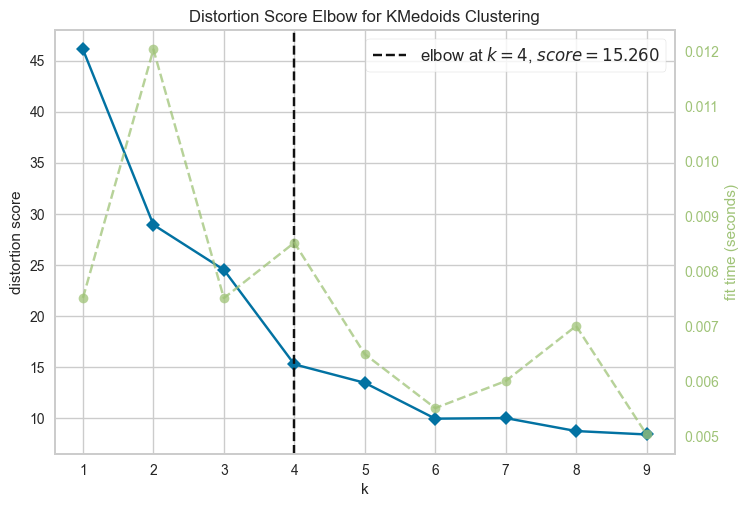

In [48]:
elbowCurveVisualizer(processed_train_data, 1, 10)

As the plot suggests, a possible optimal value for k might be 3. However, since there is no clear elbow even in this plot, we will compute the average silhouette scores for each k and the silhouette scores for each cluster for each k to determine the optimal value.

The average silhouette scores will be represented as a red dotted line.

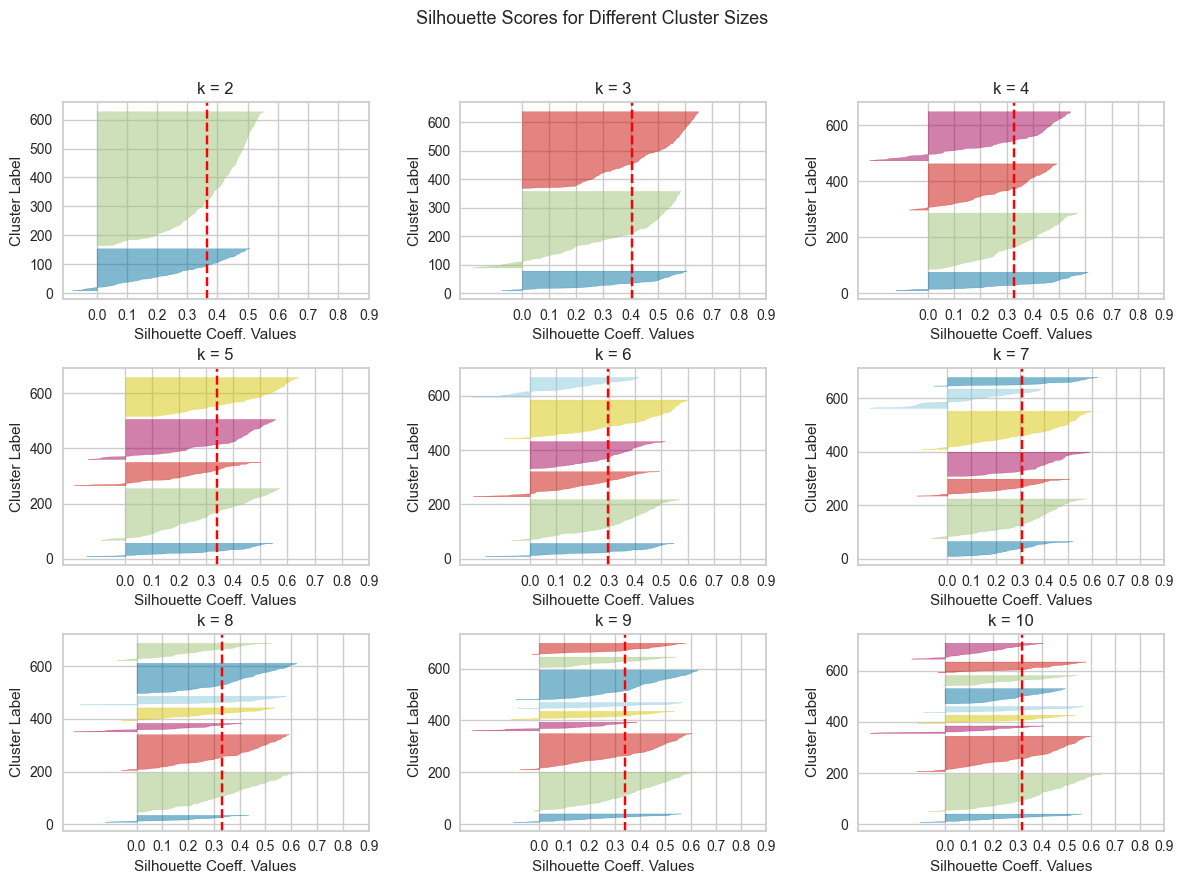

Top Five Silhouette Scores:
2 Clusters: 0.4057
3 Clusters: 0.3652
4 Clusters: 0.3423
5 Clusters: 0.3380
6 Clusters: 0.3320


In [49]:
silhouetteVisualizer(processed_train_data, 2, 10)

Since the current goal is to decide which value to pick for k using the silhouette plots, we need to check the following:

- For a given k, all clusters should have a silhouette score higher than the average score of the dataset (represented by the red dotted line in each plot).
- Additionally, there should not be wide fluctuations in the size of the clusters (the width of the clusters in the plot represents their size).

Considering these conditions and taking into account the computed silhouette scores and plots, we choose 5 as the optimal value for k, despite the presence of a small cluster w.r.t. the others.

In [50]:
k = 5

## **Performing K-Means**

In [51]:
kmedoid = KMedoidsClustering(k, trainClusterDF, processed_train_data, 42)

In [52]:
testClusterDF = testTracksDF.dropna(subset=['Genre'])
testClusterDF_tracks_encoded = pd.get_dummies(testClusterDF, columns=['Genre'])
X_test = testClusterDF_tracks_encoded[features]

test_clusters = kmedoid.predict(X_test)
testClusterDF['Cluster'] = test_clusters

scatterPlot(testClusterDF, 'Loudness', 'Energy', 'Cluster', None, tit = "Clusters - Loudness/Energy")
scatterPlot3D(testClusterDF, 'Energy', 'Liveness', 'Loudness', 'Cluster',
                None, tit = "Clusters - Energy/Liveness/Loudness")

## **Tracks  Suggestion**

Firstly, we will randomly select a song from the training set, which will be used to suggest songs from the test set. Additionally, we will define the number of songs we want to suggest.
This selected song and the number of suggestions will be used consistently throughout the clustering process, allowing for proper comparison of the results. The suggestions are computed using the Euclidean Distance.

In [53]:
num_recommendations = 5

In [54]:
trainTrackIndex = random.randint(0, len(trainTracksDF))
trainTrack = trainTracksDF.iloc[trainTrackIndex]
print("The track is: \"%s - %s\"." % (trainTrack['Name'], trainTrack['Artist']) )

The track is: "The Beach - Wolf Alice".


In [55]:
trackCluster = trainClusterDF[trainClusterDF['Name'] == trainTrack['Name']]
print("The track found in the test set is: \"%s - %s\"." % (trackCluster['Name'].values[0], trackCluster['Artist'].values[0]))

trainTrackCluster = trackCluster['Cluster'].values[0]
print("The track's cluster is: %s." % str(trainTrackCluster))

The track found in the test set is: "The Beach - Wolf Alice".
The track's cluster is: 4.


In [56]:
print("The track from which the suggestions will be made is \"%s\" who's artist is \"%s\"." % (trainTrack['Name'], trainTrack['Artist']) )
print("========================================================================================================================================")

recommendations = recommend_songs(testClusterDF, trainTrack, trainTrackCluster, num_recommendations, features)
recommendations_links = []

for x in range(len(recommendations)):
  recommendations_links.append(getTrackPreview(recommendations[x]['Name'], recommendations[x]['Artist']))

for x in range(len(recommendations)):
  print(str(x+1) + "° Track: " + recommendations[x]['Name'] + " - Artist: " + recommendations[x]['Artist'])
  print("Preview: ", recommendations_links[x])
print("========================================================================================================================================")

The track from which the suggestions will be made is "The Beach" who's artist is "Wolf Alice".


1° Track: Happier - Artist: Ed Sheeran
Preview:  https://p.scdn.co/mp3-preview/f4944de04b857647b920811fae9a1abfb27d7f8b?cid=978d7e659f4440609a2399c869cc3e27
2° Track: Easy On Me - Artist: Adele
Preview:  https://p.scdn.co/mp3-preview/a0cd8077c79a4aa3dcaa68bbc5ecdeda46e8d13f?cid=978d7e659f4440609a2399c869cc3e27
3° Track: Don't - Artist: Bryson Tiller
Preview:  None
4° Track: WITHOUT YOU - Artist: The Kid LAROI
Preview:  https://p.scdn.co/mp3-preview/0cacbf2acaef9fc50d9ecd1f29eb33e543a5bc63?cid=978d7e659f4440609a2399c869cc3e27
5° Track: Stay With Me - Artist: Sam Smith
Preview:  None
